In [ ]:
import streamlit as st
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
import plotly.graph_objects as go
import pickle

In [118]:
def plot_candlesticks(df_test):
    fig = go.Figure()

    fig.add_trace(
        go.Candlestick(
            x=df_test['Date'],
            open=df_test['Open'],
            high=df_test['High'],
            low=df_test['Low'],
            close=df_test['Close'],
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Line(x=df_test['Date'], y=df_test[f'target_ma'], name=f'Target SMA')
    )

    df_pattern = (
        df_test[df_test['pred']]
        .groupby((~df_test['pred']).cumsum())
        ['Date']
        .agg(['first', 'last'])
    )

    last_date_included = False
    for idx, row in df_pattern.iterrows():
        fig.add_vrect(
            x0=row['first'],
            x1=row['last'],
            line_width=0,
            fillcolor='green',
            opacity=0.2,
        )
        print(f"first : {row['first']} last: {row['last']}")
        if df_test.iloc[-1]['Date'] >= row['first'] and df_test.iloc[-1]['Date'] <= row['last'] and (row['last']!=row['first']):
            last_date_included = True
        firstgreenflag=True
    
    print( last_date_included)
    # Check if the last entry has pred as True and is not included in any green fill
    if df_test.iloc[-1]['pred'] and not last_date_included:
        fig.add_vline(
            x=df_test.iloc[-1]['Date'], 
            line_width=5, 
            line_color='green'
        )

    fig.update_layout(
        xaxis_rangeslider_visible=True,
        xaxis_title='Date',
        yaxis_title='Price ($)',
        title='Classified Results on SPY',
        width=1000,
        height=700,
    )
    
    fig.show()

In [1]:
df = yf.download("NVDA").reset_index()

[*********************100%%**********************]  1 of 1 completed


In [95]:
# Feature deriving
# Distance from the moving averages
def create_feature_cols(df):
    for m in [10, 20, 30, 50, 100]:
        df[f'feat_dist_from_ma_{m}'] = df['Close']/df['Close'].rolling(m).mean()-1

    # Distance from n day max/min
    for m in [3, 5, 10, 15, 20, 30, 50, 100]:
        df[f'feat_dist_from_max_{m}'] = df['Close']/df['High'].rolling(m).max()-1
        df[f'feat_dist_from_min_{m}'] = df['Close']/df['Low'].rolling(m).min()-1

    # Price distance
    for m in [1, 2, 3, 4, 5, 10, 15, 20, 30, 50, 100]:
        df[f'feat_price_dist_{m}'] = df['Close']/df['Close'].shift(m)-1

    # Target = if the price above the 20 ma in 5 days time
    df['target_ma'] = df['Close'].rolling(20).mean()
    df['price_above_ma'] = df['Close'] > df['target_ma']
    return df
df = create_feature_cols(df)
df['target'] = df['price_above_ma'].astype(int).shift(-5)
df = df.dropna()

In [46]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,feat_dist_from_ma_10,feat_dist_from_ma_20,feat_dist_from_ma_30,...,feat_price_dist_5,feat_price_dist_10,feat_price_dist_15,feat_price_dist_20,feat_price_dist_30,feat_price_dist_50,feat_price_dist_100,target_ma,price_above_ma,target
6265,2023-12-14,483.899994,486.700012,474.220001,483.500000,483.500000,39123200,0.030548,0.011756,0.017892,...,0.037643,0.033782,-0.007513,-0.011005,0.142351,0.097841,0.058473,477.882001,True,1.0
6266,2023-12-15,481.940002,494.040009,481.200012,488.899994,488.899994,47947800,0.037359,0.023688,0.025386,...,0.029133,0.045440,0.023317,-0.011924,0.123753,0.094030,0.075640,477.587001,True,1.0
6267,2023-12-18,494.000000,504.329987,491.500000,500.769989,500.769989,41258700,0.052347,0.047687,0.046570,...,0.073991,0.100352,0.038037,0.015802,0.112699,0.094292,0.091002,477.976500,True,1.0
6268,2023-12-19,494.239990,497.000000,488.950012,496.040009,496.040009,46444400,0.035795,0.038666,0.033910,...,0.040854,0.065241,0.037285,-0.015969,0.084217,0.095664,0.061048,477.574001,True,1.0
6269,2023-12-20,496.549988,499.989990,480.980011,481.109985,481.109985,39789400,-0.000822,0.009341,0.001291,...,0.000478,0.057315,-0.000602,-0.036701,0.046915,0.050504,0.029575,476.657500,True,1.0
6270,2023-12-21,488.109985,490.950012,484.190002,489.899994,489.899994,30042500,0.012399,0.027487,0.017879,...,0.013237,0.051378,0.047466,0.005624,0.051874,0.046661,0.053390,476.794499,True,1.0
6271,2023-12-22,491.950012,493.829987,484.670013,488.299988,488.299988,25213900,0.006339,0.023000,0.013235,...,-0.001227,0.027870,0.044157,0.022061,0.040043,0.040153,0.103029,477.321498,True,1.0
6272,2023-12-26,489.679993,496.000000,489.600006,492.790009,492.790009,24420000,0.010072,0.031287,0.021885,...,-0.015935,0.056877,0.082817,0.021496,0.019530,0.083984,0.107020,477.839998,True,0.0
6273,2023-12-27,495.109985,496.799988,490.850006,494.170013,494.170013,23364800,0.009260,0.032450,0.024182,...,-0.003770,0.036931,0.061225,0.033375,0.016392,0.072069,0.106021,478.637999,True,0.0
6274,2023-12-28,496.429993,498.839996,494.119995,495.220001,495.220001,24658700,0.008451,0.033153,0.026453,...,0.029328,0.029820,0.088324,0.028708,-0.002699,0.127088,0.090385,479.328999,True,1.0


In [120]:
feat_cols = [col for col in df.columns if 'feat' in col]
train_until = '2019-01-01'
test_until = '2023-12-10'

x_train = df[df['Date'] < train_until][feat_cols]
y_train = df[df['Date'] < train_until]['target']

# df2 = yf.download("NVDA").reset_index()
# df2 = create_feature_cols(df2)
x_test = df[(df['Date'] >= train_until) & (df['Date'] <= test_until)][feat_cols]
y_test = df[(df['Date'] >= train_until) & (df['Date'] <= test_until)]['target']

clf = RandomForestClassifier(
n_estimators=100,
max_depth=3,
random_state=42,
class_weight='balanced',
)

clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Calculate accuracy and precision for training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)

# Calculate accuracy and precision for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)

In [121]:
df_test = df[(df['Date'] >= train_until) & (df['Date'] <= test_until) ].reset_index(drop=True)
df_test['pred_prob'] = clf.predict_proba(x_test)[:, 1]
df_test['pred'] = df_test['pred_prob'] > 0.5

In [122]:
df_test

,Date,Open,High,Low,Close,Adj Close,Volume,feat_dist_from_ma_10,feat_dist_from_ma_20,feat_dist_from_ma_30,...,feat_price_dist_15,feat_price_dist_20,feat_price_dist_30,feat_price_dist_50,feat_price_dist_100,target_ma,price_above_ma,target,pred_prob,pred
0,2019-01-02,32.660000,34.619999,32.512501,34.055000,33.790470,50875200,0.012909,-0.049327,-0.071506,...,-0.102990,-0.166493,-0.326943,-0.431303,-0.472874,35.822000,False,1.0,0.275339,False
1,2019-01-03,33.447498,33.790001,31.922501,31.997499,31.748962,70555200,-0.034686,-0.093462,-0.120319,...,-0.136312,-0.247295,-0.221614,-0.441506,-0.500936,35.296375,False,1.0,0.177997,False
2,2019-01-04,32.735001,34.432499,32.424999,34.047501,33.783035,58562000,0.028960,-0.028183,-0.062132,...,-0.085359,-0.133155,-0.058811,-0.410994,-0.465481,35.034875,False,1.0,0.379499,False
3,2019-01-07,34.625000,36.222500,34.107498,35.849998,35.571533,70916000,0.076682,0.028731,-0.011191,...,-0.036873,-0.094068,-0.038100,-0.351307,-0.440106,34.848750,True,1.0,0.603805,True
4,2019-01-08,36.672501,36.695000,34.224998,34.957500,34.685966,78601600,0.041851,0.005928,-0.034725,...,-0.045203,-0.052706,-0.033723,-0.298781,-0.465134,34.751500,True,1.0,0.522757,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2023-12-04,460.769989,460.769989,450.100006,455.100006,455.059998,43754300,-0.052059,-0.051480,-0.011812,...,-0.058446,0.011221,0.099621,0.093727,-0.010157,479.800002,False,0.0,0.213209,False
1240,2023-12-05,454.660004,466.000000,452.709991,465.660004,465.660004,37171800,-0.022236,-0.030294,0.008496,...,-0.042246,0.017814,0.083560,0.102885,0.024126,480.207501,False,0.0,0.364447,False
1241,2023-12-06,472.149994,473.869995,454.119995,455.029999,455.029999,38059000,-0.035563,-0.051984,-0.015833,...,-0.083635,-0.009836,0.042141,0.085705,-0.020619,479.981502,False,1.0,0.236604,False
1242,2023-12-07,457.000000,466.290009,456.040009,465.959991,465.959991,35082300,-0.007939,-0.029235,0.004319,...,-0.046883,0.000472,0.115297,0.097203,-0.018908,479.992502,False,1.0,0.453290,False


In [123]:
df_test = df2[df2['Date'] > test_until].reset_index(drop=True)
df_test['pred_prob'] = clf.predict_proba(df_test[x_test.columns])[:, 1]
df_test['pred'] = df_test['pred_prob'] > 0.5

In [124]:
df_test

,Date,Open,High,Low,Close,Adj Close,Volume,feat_dist_from_ma_10,feat_dist_from_ma_20,feat_dist_from_ma_30,...,feat_price_dist_10,feat_price_dist_15,feat_price_dist_20,feat_price_dist_30,feat_price_dist_50,feat_price_dist_100,target_ma,price_above_ma,pred_prob,pred
0,2023-12-11,474.910004,475.309998,458.299988,466.269989,466.269989,50972800,-0.003279,-0.027422,-0.004530,...,-0.033477,-0.054181,-0.035337,0.151284,0.071910,0.024319,479.416501,False,0.463544,False
1,2023-12-12,460.459991,476.660004,460.459991,476.570007,476.570007,37238700,0.019096,-0.004938,0.012778,...,-0.003429,-0.054593,-0.019807,0.157819,0.064200,0.075560,478.935001,False,0.572795,True
2,2023-12-13,476.290009,485.940002,476.079987,480.880005,480.880005,44779200,0.028427,0.005707,0.016675,...,-0.001080,-0.037162,-0.031577,0.179206,0.105039,0.077916,478.151001,True,0.603917,True
3,2023-12-14,483.899994,486.700012,474.220001,483.500000,483.500000,39123200,0.030548,0.011756,0.017892,...,0.033782,-0.007513,-0.011005,0.142351,0.097841,0.058473,477.882001,True,0.631075,True
4,2023-12-15,481.940002,494.040009,481.200012,488.899994,488.899994,47947800,0.037359,0.023688,0.025386,...,0.045440,0.023317,-0.011924,0.123753,0.094030,0.075640,477.587001,True,0.656240,True
5,2023-12-18,494.000000,504.329987,491.500000,500.769989,500.769989,41258700,0.052347,0.047687,0.046570,...,0.100352,0.038037,0.015802,0.112699,0.094292,0.091002,477.976500,True,0.757118,True
6,2023-12-19,494.239990,497.000000,488.950012,496.040009,496.040009,46444400,0.035795,0.038666,0.033910,...,0.065241,0.037285,-0.015969,0.084217,0.095664,0.061048,477.574001,True,0.724187,True
7,2023-12-20,496.549988,499.989990,480.980011,481.109985,481.109985,39789400,-0.000822,0.009341,0.001291,...,0.057315,-0.000602,-0.036701,0.046915,0.050504,0.029575,476.657500,True,0.505493,True
8,2023-12-21,488.109985,490.950012,484.190002,489.899994,489.899994,30042500,0.012399,0.027487,0.017879,...,0.051378,0.047466,0.005624,0.051874,0.046661,0.053390,476.794499,True,0.626597,True
9,2023-12-22,491.950012,493.829987,484.670013,488.299988,488.299988,25213900,0.006339,0.023000,0.013235,...,0.027870,0.044157,0.022061,0.040043,0.040153,0.103029,477.321498,True,0.586244,True


first : 2023-12-12 00:00:00 last: 2023-12-29 00:00:00
first : 2024-01-05 00:00:00 last: 2024-01-05 00:00:00
False


C:\Users\doraemon\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




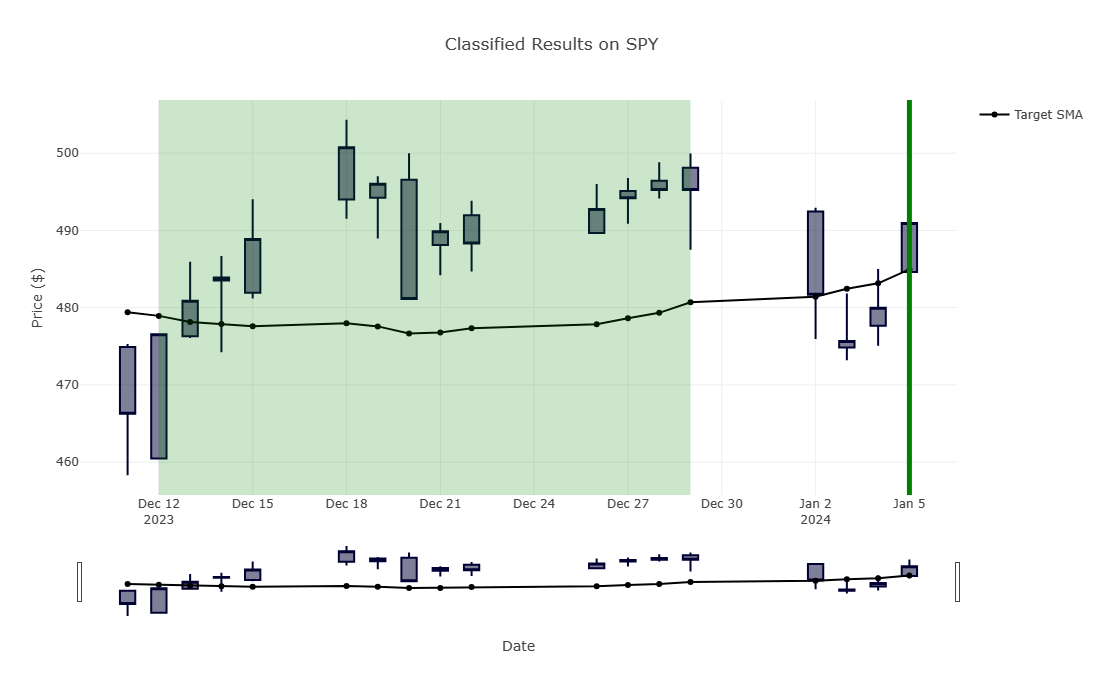

In [125]:
plot_candlesticks(df_test)

In [126]:
x_test.columns

Index(['feat_dist_from_ma_10', 'feat_dist_from_ma_20', 'feat_dist_from_ma_30',
       'feat_dist_from_ma_50', 'feat_dist_from_ma_100', 'feat_dist_from_max_3',
       'feat_dist_from_min_3', 'feat_dist_from_max_5', 'feat_dist_from_min_5',
       'feat_dist_from_max_10', 'feat_dist_from_min_10',
       'feat_dist_from_max_15', 'feat_dist_from_min_15',
       'feat_dist_from_max_20', 'feat_dist_from_min_20',
       'feat_dist_from_max_30', 'feat_dist_from_min_30',
       'feat_dist_from_max_50', 'feat_dist_from_min_50',
       'feat_dist_from_max_100', 'feat_dist_from_min_100', 'feat_price_dist_1',
       'feat_price_dist_2', 'feat_price_dist_3', 'feat_price_dist_4',
       'feat_price_dist_5', 'feat_price_dist_10', 'feat_price_dist_15',
       'feat_price_dist_20', 'feat_price_dist_30', 'feat_price_dist_50',
       'feat_price_dist_100'],
      dtype='object')